<a href="https://colab.research.google.com/github/SofyaKirsanova/Log_Analysis/blob/main/Word2Vec_%26_HDFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data size: 35502
Example words (start):  ['081109', '203615', '148', 'info', 'dfs', 'datanode$packetresponder', 'packetresponder', '1', 'for', 'block']
Example words (end):  ['9', '207', '59759', 'dest', '/10', '250', '9', '207', '50010', '']
Most common words (+UNK): [['UNK', 6364], ('dfs', 2000), ('info', 1920), ('251', 1408), ('block', 1241)]
Vocabulary size:  179
data: ['081109', 'dfs', 'dfs', 'info', 'dfs', 'datanode$packetresponder', 'packetresponder', '1']

with window_size = 2:
    batch: ['dfs', 'dfs', 'dfs', 'dfs', 'info', 'info', 'info', 'info']
    labels: ['081109', 'dfs', 'info', 'dfs', 'dfs', 'dfs', 'dfs', 'datanode$packetresponder']
Initialized
Average loss at step 5000: 2.888642
Average loss at step 10000: 2.708540
Average loss at step 15000: 2.693304
Average loss at step 20000: 2.688755
Average loss at step 25000: 2.674001
Average loss at step 30000: 2.668377
Average loss at step 35000: 2.676826
Average loss at step 40000: 2.671961
Average loss at step 45000: 2.667118

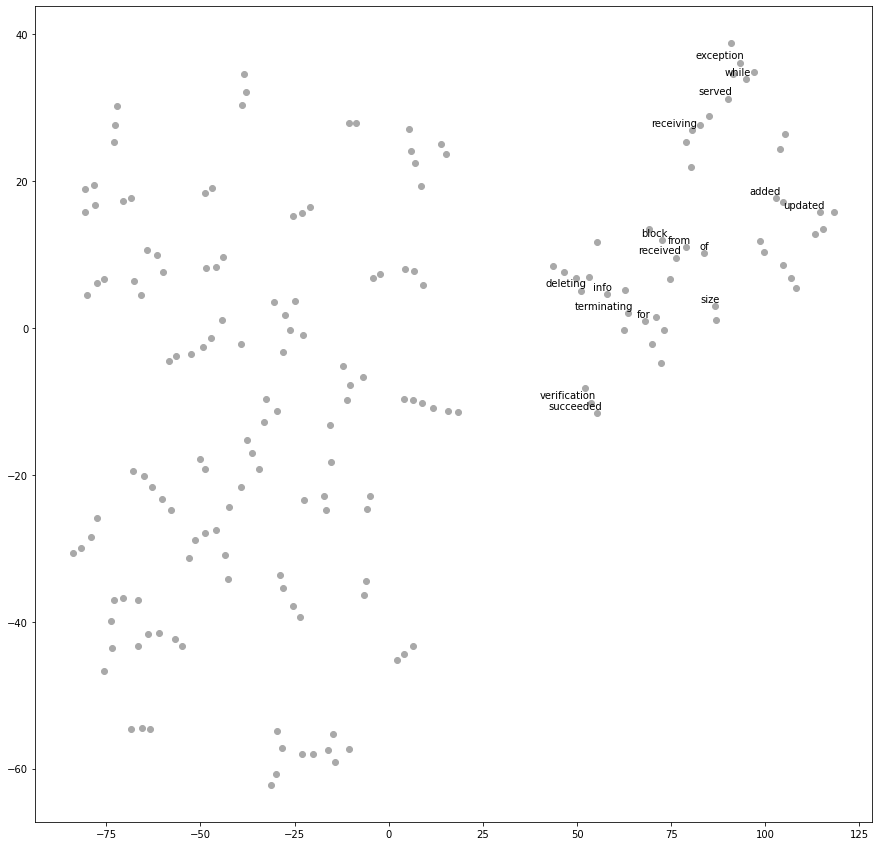

In [ ]:
%matplotlib inline
import collections
import math
import numpy as np
import os
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from matplotlib import pylab
from sklearn.manifold import TSNE
import operator
from math import ceil

def preprocess_text(text):
    text = text.lower()
    text = text.replace('.',' ') 
    text = text.replace(',',' ')
    text = text.replace('-',' ')
    text = text.replace('%','')
    text = text.replace(':',' ')
    text = text.replace('(','')
    text = text.replace(')','')
    text = text.replace('\n',' ')
    text = text.replace('[',' ')
    text = text.replace(']',' ')
    text = text.replace('"',' ')
    text = text.replace('  ',' ')
    return text

def read_data(filename):
  filename = '/HDFS_2k.txt'
  with open(filename,'r') as f:
    data = []
    file_string = f.read()
    file_string = preprocess_text(file_string)
    file_string = file_string.split(' ')
    data.extend(file_string)
  return data
  
words = read_data('HDFS_2k.txt')
print('Data size: %d' % len(words))
print('Example words (start): ', words[:10])
print('Example words (end): ', words[-10:])

vocabulary_size = 0
def build_dataset(words):
  global vocabulary_size
  count = [['UNK', -1]] 

  count.extend(collections.Counter(words).most_common())
  dictionary = dict()

  for word, c in count:
    if c < 10:
        continue
    dictionary[word] = len(dictionary)
    vocabulary_size += 1
    
  data = list()
  unk_count = 0
  
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  
      unk_count = unk_count + 1
    data.append(index)
    
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK):', count[:5])
print('Vocabulary size: ', vocabulary_size)

data_index = 0

def generate_batch(batch_size, window_size):
  global data_index 
  
  batch = np.ndarray(shape = (batch_size), dtype = np.int32)
  labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
  span = 2 * window_size + 1
  queue = collections.deque(maxlen = span)
  
  for _ in range(span): 
    queue.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  
  for i in range(batch_size // (2 * window_size)):
    k = 0
    for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
      batch[i * (2*window_size) + k] = queue[window_size]
      labels[i * (2*window_size) + k, 0] = queue[j]
      k += 1 

    queue.append(data[data_index])
    data_index = (data_index + np.random.randint(window_size)) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

data_index = 0
batch, labels = generate_batch(batch_size = 8, window_size = 2)
print('\nwith window_size = %d:' %2)
print('    batch:', [reverse_dictionary[bi] for bi in batch])
print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

batch_size = 128 
embedding_size = 64 
window_size = 4 

num_sampled = 32
tf.compat.v1.reset_default_graph()

train_dataset = tf.placeholder(tf.int32, shape = [batch_size]) 
train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1]) 

embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)) 
softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=0.1 / math.sqrt(embedding_size)))
softmax_biases = tf.Variable(tf.random_uniform([vocabulary_size],-0.01,0.01))
embed = tf.nn.embedding_lookup(embeddings, train_dataset) 
loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights = softmax_weights, biases = softmax_biases, inputs = embed, labels = train_labels, 
                      num_sampled = num_sampled, num_classes = vocabulary_size))

optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm

num_steps = 250001
session = tf.InteractiveSession()
tf.global_variables_initializer().run()
print('Initialized')
average_loss = 0

for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, window_size)

    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)

    average_loss += l
    if (step+1) % 5000 == 0:
      if step > 0:
        average_loss = average_loss / 5000
      print('Average loss at step %d: %f' % (step + 1, average_loss))
      average_loss = 0
sg_embeddings = normalized_embeddings.eval()
session.close()

tsne = TSNE(perplexity = 5, n_components = 2, init = 'pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(sg_embeddings)

selected_words = ['for','info','block','terminating','received','receiving','updated', 'of','size','from','added','verification', 'succeeded', 'deleting', 'served', 'while', 'exception', 'blockMap', 'PacketResponder', 'terminating']
words = [reverse_dictionary[i] for i in np.arange(vocabulary_size)]
pylab.figure(figsize = (15,15))
for i, label in enumerate(words):
    x, y = two_d_embeddings[i,:]
    pylab.scatter(x, y, c = 'darkgray')   
    if label in selected_words:
        pylab.annotate(label, xy = (x, y), xytext = (5, 2), textcoords = 'offset points',
                       ha = 'right', va = 'bottom', fontsize = 10)
        
pylab.show()
